In [ ]:
import warnings
warnings.filterwarnings('ignore')

import re
import os
import string
import datetime as dt
import shutil
import json
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text

device = torch.device('cuda') if torch.cuda.is_available else 'cpu'
import datasets

from collections import Counter

In [ ]:
# Cosine Simularity
class Similarity(nn.Module):
    """
    Dot product or cosine similarity
    """

    def __init__(self, temp = 0.05):
        super().__init__()
        self.temp = temp
        self.cos = nn.CosineSimilarity(dim=-1)

    def forward(self, x, y):
        return self.cos(x, y) / self.temp

# Backbone Model
class Custom_tf_encoder(nn.Module):
    def __init__(self, used_word, embed_dim, nhead, encoder_layers, dropout=0.1, max_len=500):
        super().__init__()
        self.embedding_layer = nn.Embedding(used_word, embed_dim)
        self.encoders = nn.ModuleList([nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=nhead, 
            dim_feedforward=(embed_dim*2), 
            dropout=dropout, 
            activation='gelu', 
            batch_first=True) for _ in range(encoder_layers)])
    
    def mk_padding_mask(self, text):
        # <pad>: 0
        return torch.eq(text, 0)
        
    def forward(self, text):
        x = self.embedding_layer(text)
        padding_mask = self.mk_padding_mask(text).to(x.device)
        for layer in self.encoders:
            x = layer(x, src_key_padding_mask=padding_mask)
        
        return x

In [ ]:
# SIMCES Contrastive Model
class transformer_cl(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.Similarity = Similarity()
        
    def forward(self, x):
        emb_a = self.backbone(x)
        emb_b = self.backbone(x)
        emb_a, emb_b = emb_a[:, -1], emb_b[:, -1]
        return emb_a, emb_b

In [ ]:
# Pytorch Training
def cl_train(model, train_data, loss_fn, optimizer, device):
    cl_train_loss = 0
    model.train()
    for data in train_data:
        output = model(data.to(device))
        label = torch.arange(len(data)).to(device)
        
        optimizer.zero_grad()
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        cl_train_loss += loss_fn(output, label)
    return cl_train_loss

def cl_valid(model, valid_data, loss_fn, device):
    cl_valid_loss = 0
    model.eval()
    for data in valid_data:
        output = model(data.to(device))
        label = torch.arange(len(data)).to(device)
        cl_valid_loss += loss_fn(output, label)
        
    return cl_valid_loss


def Training(epochs, model, train_batch, valid_batch, loss_fn, optimizer, save_path, device):
    val_best_loss = float("inf")
    for epoch in range(1, epochs+1):
        train_loss, valid_loss, best_valid_loss = 0, 0, float('inf')
        train_loss += cl_train(model, train_batch, loss_fn, optimizer, device)
        valid_loss += cl_valid(model, valid_batch, loss_fn, device)
        
        # best save only, early_stopping 구현
        if valid_loss < val_best_loss:
            es_patience = 0
            
            if not os.path.exists(os.path.dirname(save_path)):
                os.makedirs(os.path.dirname(save_path))
            torch.save(model, save_path)
        else:
            es_patience += 1
            if es_patience == 50:
                break
                print(f"Train Stopped at Epoch {epoch}")
        print(f"Train_loss: {train_loss}, Valid_loss: {valid_loss}")

In [ ]:
# Data Preprocessing
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

def get_text_label(raw_text):
    prep_text = custom_standardization(raw_text).numpy()
    list_text = [data.decode('utf-8').replace('  ', ' ') for data in prep_text]
    return list_text

def get_length_percentage(dataset, limit):
    count_under_limit = 0
    for x in dataset:
        if len(x) <= limit:
            count_under_limit += 1
    answer = (count_under_limit/len(dataset))*100
    print(f'{round(answer, 2)}% contains under {limit} words')

In [ ]:
imdb = datasets.load_dataset("imdb")
print(imdb)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
train_x, train_y, test_x, test_y = imdb['train']['text'], imdb['train']['label'], imdb['test']['text'], imdb['test']['label']
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [ ]:
train_x, val_x, test_x = (
    get_text_label(train_x), get_text_label(val_x), get_text_label(test_x) )

tokenizer = text.Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(train_x)

mean: 1259.11885
(700, 2480) (600, 1912) (800, 1872) (900, 1443) (1000, 1274) (1100, 976) (1200, 796) (500, 773) (1300, 728) (400, 707)
10.51% contains under 500 words


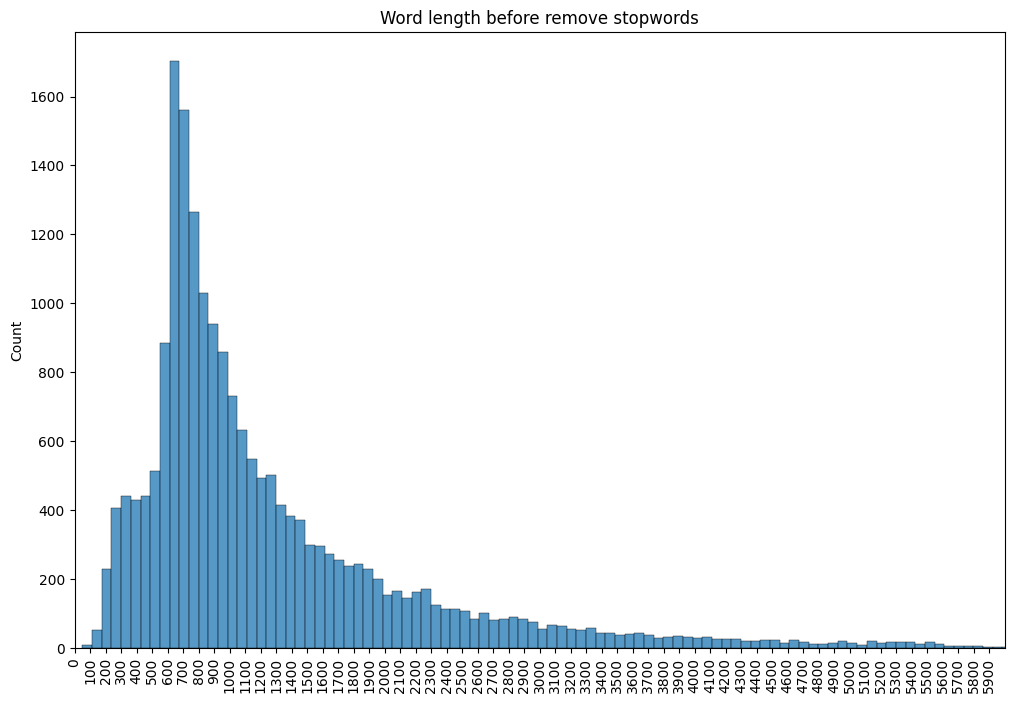

In [ ]:
length_count = np.array([len(train_t) for train_t in train_x])
upper_length_count = np.array([round(len(train_t), -2) for train_t in train_x])

plt.figure(figsize = (12, 8))
sns.histplot(length_count)
plt.xlim(0, 6000)
plt.xticks(np.arange(0, 6000, 100), rotation=90)
plt.title("Word length before remove stopwords")
print(f'mean: {length_count.mean()}')

# 700~800 사이가 제일 많다.
print(*sorted(Counter(upper_length_count).items(), key=lambda x: -x[1])[:10])
get_length_percentage(train_x, 500)